## Libraries

In [1]:
import numpy as np
import matplotlib . pyplot as plt
from PIL import Image
from scipy.ndimage import label
import pandas as pd
from scipy.optimize import minimize
import cv2
import csv
from tensorflow.keras.models import load_model

### Read CSV and save png

In [2]:
def read_csv_adobe ( csv_path ):
    np_path_XYs = np . genfromtxt ( csv_path , delimiter = ',')
    path_XYs = []
    for i in np . unique ( np_path_XYs [: , 0]):
        npXYs = np_path_XYs [ np_path_XYs [: , 0] == i ][: , 1:]
        XYs = []
        for j in np . unique ( npXYs [: , 0]):
            XY = npXYs [ npXYs [: , 0] == j ][: , 1:]
            XYs . append ( XY )
            path_XYs . append ( XYs )
    return path_XYs

    
def plot_csv(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(6, 6))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    
    ax.set_aspect('equal')
    ax.axis('off') 
    plt.show()
    
def plot_and_save(paths_XYs, save_path=None):
    fig, ax = plt.subplots(tight_layout=True, figsize=(6, 6))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    
    ax.set_aspect('equal')
    ax.axis('off')
    if(save_path):
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, facecolor='white')
    plt.show()


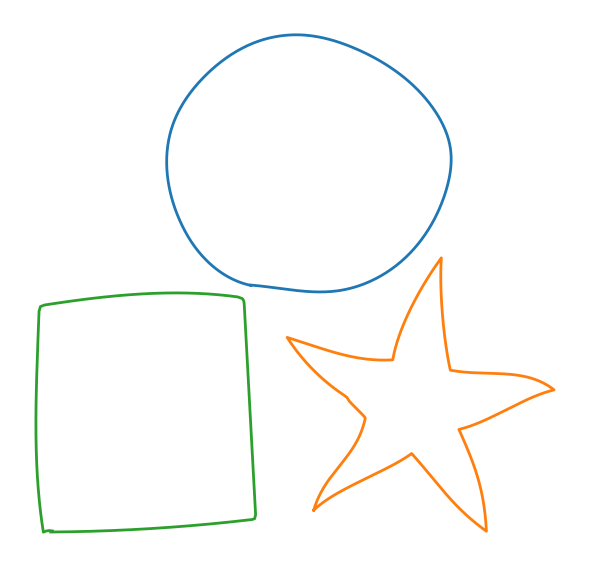

In [3]:
plot_and_save(read_csv_adobe('../problems/isolated.csv'), 'files/original.png')

### Image to Data Points

In [4]:
def process_image(image_path, threshold=200):
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert('L')
    
    # Convert image to black and white
    bw_image = image.point(lambda p: p > threshold and 255)
    bw_array = np.array(bw_image)
    
    # Find connected components
    labeled_array, num_features = label(bw_array == 0)  # Find connected components where pixel is black (0)
    
    # Extract coordinates of points in each connected component
    connected_components = {}
    for component_id in range(1, num_features + 1):
        coords = np.column_stack(np.where(labeled_array == component_id))
        connected_components[component_id] = coords
    
    return connected_components

def plot_connected_components(connected_components, image_shape):
    # Plot the connected components
    fig, ax = plt.subplots(figsize=(6, 6))
    colors = plt.cm.get_cmap('hsv', len(connected_components) + 1)
    
    for component_id, coords in connected_components.items():
        ax.plot(coords[:, 1], image_shape[0] - coords[:, 0], 'o', markersize=1, color=colors(component_id))
    
    ax.set_aspect('equal')
    ax.axis('off')
    plt.show()


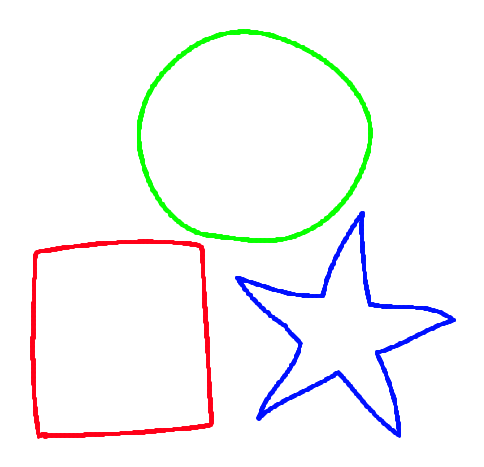

In [5]:
image_path = 'files/original.png'  # Replace with your image path
connected_components = process_image(image_path)
image_shape = Image.open(image_path).size[::-1]  # Get the image shape (height, width)
plot_connected_components(connected_components, image_shape)

In [6]:
# Prepare data for CSV
data = []
for shape_id, points in connected_components.items():
    for point in points:
        data.append([shape_id, 0, point[0], point[1]])

# Create a DataFrame
df = pd.DataFrame(data, columns=['ID', 'Zero', 'X', 'Y'])

# Save to CSV
df.to_csv('files/connected_components.csv', index=False, header=False)


In [7]:
# Generate a CSV for each ID
for shape_id, points in connected_components.items():
    # Prepare data for CSV
    data = [[shape_id, 0, point[0], point[1]] for point in points]
    
    # Create a DataFrame
    df = pd.DataFrame(data, columns=['ID', 'Zero', 'X', 'Y'])
    
    # Save to CSV
    filename = f'files/connected_component_{shape_id}.csv'
    df.to_csv(filename, index=False, header=False)
    print(f'Saved {filename}')


Saved files/connected_component_1.csv
Saved files/connected_component_2.csv
Saved files/connected_component_3.csv


In [8]:
def plot_csv_by_id(csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file, header=None, names=['ID', 'Zero', 'X', 'Y'])
    
    # Unique IDs
    unique_ids = df['ID'].unique()
    
    # Plot each ID with a different color
    plt.figure(figsize=(4, 4))
    for shape_id in unique_ids:
        subset = df[df['ID'] == shape_id]
        plt.scatter(subset['X'], subset['Y'], label=f'ID {shape_id}', s=1)
    
    # Add legend, labels, and title
    plt.axis('off')
    plt.gca().invert_yaxis()  # Invert Y axis to match typical image coordinates
    plt.show()

## Fitting cirves

In [9]:
def read_csv(file_path):
    data = pd.read_csv(file_path)
    x = data.iloc[:, -2].values
    y = data.iloc[:, -1].values
    return x, y

# Function to save the refined points to a new CSV file
def save_csv(x, y, file_path):
    df = pd.DataFrame({'x': x, 'y': y})
    df.to_csv(file_path, index=False)

## Regularize Circle Function

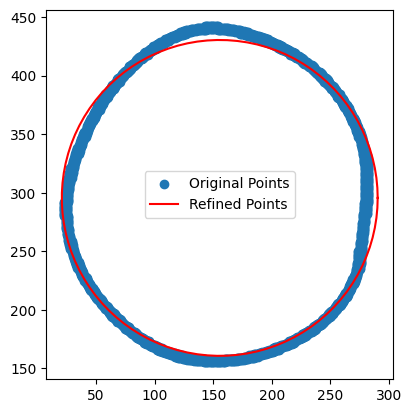

In [10]:
# Function to calculate the centroid of points
def calculate_centroid(x, y):
    return np.mean(x), np.mean(y)

# Function to calculate the average distance from the centroid to the points
def calculate_radius(x, y, cx, cy):
    distances = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
    return np.mean(distances)

# Function to fit a circle to points using least squares
def fit_circle_least_squares(x, y):
    def cost_function(params):
        cx, cy, r = params
        return np.sum((np.sqrt((x - cx) ** 2 + (y - cy) ** 2) - r) ** 2)
    
    initial_guess = [np.mean(x), np.mean(y), np.mean(np.sqrt((x - np.mean(x)) ** 2 + (y - np.mean(y)) ** 2))]
    result = minimize(cost_function, initial_guess, method='Nelder-Mead')
    cx, cy, r = result.x
    return cx, cy, r

# Function to generate points for a perfect circle centered at (cx, cy)
def generate_circle_points(cx, cy, radius, num_points=100):
    angles = np.linspace(0, 2 * np.pi, num_points)
    circle_x = cx + radius * np.cos(angles)
    circle_y = cy + radius * np.sin(angles)
    return circle_x, circle_y

# Function to refine points to match a perfect circle
def refine_points_to_circle(x, y):
    # Calculate the centroid of the original points
    cx, cy = calculate_centroid(x, y)

    # Calculate the radius using the average distance from the centroid
    radius = calculate_radius(x, y, cx, cy)

    # Generate perfect circle points
    circle_x, circle_y = generate_circle_points(cx, cy, radius)

    return circle_x, circle_y

# Main function to process the CSV file
def process_circle(input_file, output_file):
    x, y = read_csv(input_file)

    # Plot the original points
    plt.scatter(x, y, label='Original Points')

    x_refined, y_refined = refine_points_to_circle(x, y)

    # Plot the refined points
    plt.plot(x_refined, y_refined, color='red', label='Refined Points')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    save_csv(x_refined, y_refined, output_file)

process_circle('files/connected_component_1.csv', 'files/refined_1.csv')


## Regularize Square

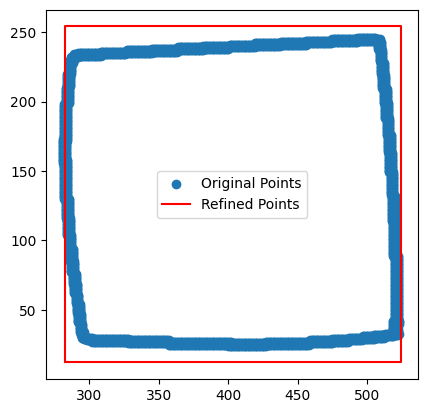

In [11]:
# Function to calculate the centroid of points
def calculate_centroid(x, y):
    return np.mean(x), np.mean(y)

# Function to find the bounding box of the points
def find_bounding_box(x, y):
    min_x, max_x = np.min(x), np.max(x)
    min_y, max_y = np.min(y), np.max(y)
    return min_x, max_x, min_y, max_y

# Function to generate points for a perfect square centered at (cx, cy)
def generate_square_points(cx, cy, side_length):
    half_side = side_length / 2
    square_x = [cx - half_side, cx + half_side, cx + half_side, cx - half_side, cx - half_side]
    square_y = [cy - half_side, cy - half_side, cy + half_side, cy + half_side, cy - half_side]
    return np.array(square_x), np.array(square_y)

# Function to refine points to match a perfect square
def refine_points_to_square(x, y):
    # Calculate the centroid of the original points
    cx, cy = calculate_centroid(x, y)

    # Find the bounding box of the original points
    min_x, max_x, min_y, max_y = find_bounding_box(x, y)
    
    # Calculate the side length of the square
    side_length = max(max_x - min_x, max_y - min_y)  # Ensure the square encloses the bounding box

    # Generate perfect square points
    square_x, square_y = generate_square_points(cx, cy, side_length)

    return square_x, square_y

# Main function to process the CSV file
def process_square(input_file, output_file):
    # Function to read CSV
    def read_csv(file):
        df = pd.read_csv(file, header=None)
        return df[2].values, df[3].values

    # Function to save CSV
    def save_csv(x, y, file):
        data = np.column_stack((np.zeros(len(x)), x, y))
        df = pd.DataFrame(data, columns=['Zero', 'X', 'Y'])
        df.to_csv(file, index=False, header=False)

    x, y = read_csv(input_file)

    # Plot the original points
    plt.scatter(x, y, label='Original Points')

    x_refined, y_refined = refine_points_to_square(x, y)

    # Plot the refined points
    plt.plot(x_refined, y_refined, color='red', label='Refined Points')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    save_csv(x_refined, y_refined, output_file)

process_square('files/connected_component_3.csv', 'files/refined_2.csv')


## Regularize Star

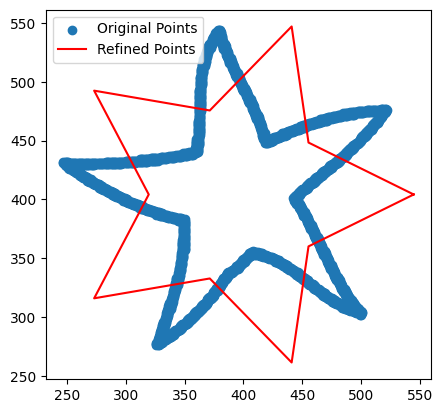

In [12]:
# Function to calculate the centroid of points
def calculate_centroid(x, y):
    return np.mean(x), np.mean(y)

# Function to generate points for a perfect star centered at (cx, cy)
def generate_star_points(cx, cy, radius, num_points=5):
    angles = np.linspace(0, 2 * np.pi, 2 * num_points + 1)
    points_x = []
    points_y = []
    for i, angle in enumerate(angles):
        if i % 2 == 0:
            points_x.append(cx + radius * np.cos(angle))
            points_y.append(cy + radius * np.sin(angle))
        else:
            points_x.append(cx + (radius / 2) * np.cos(angle))
            points_y.append(cy + (radius / 2) * np.sin(angle))
    return np.array(points_x), np.array(points_y)

# Main function to process the CSV file
def process_star(input_file, output_file):
    x, y = read_csv(input_file)

    # Plot the original points
    plt.scatter(x, y, label='Original Points')

    # Calculate the centroid of the original points
    cx, cy = calculate_centroid(x, y)

    # Assume a radius that maintains the original scale (e.g., the maximum distance from the centroid)
    radius = np.max(np.sqrt((x - cx)**2 + (y - cy)**2))

    # Generate star points
    x_refined, y_refined = generate_star_points(cx, cy, radius, num_points=5)

    # Plot the refined points
    plt.plot(np.append(x_refined, x_refined[0]), np.append(y_refined, y_refined[0]), color='red', label='Refined Points')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    save_csv(x_refined, y_refined, output_file)
    
process_star('files/connected_component_2.csv', 'files/refined_3.csv')

In [13]:
def read_csv_new(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def hough_transform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Detect lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    # Detect circles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20,
                               param1=50, param2=30, minRadius=0, maxRadius=0)
    
    return lines, circles

def detect_shapes(path_XYs):
    detected_shapes = []
    for shape in path_XYs:
        for path in shape:
            if len(path) > 1:
                # Create an empty image
                img = np.zeros((500, 500, 3), dtype=np.uint8)
                for point in path:
                    cv2.circle(img, (int(point[0]), int(point[1])), 1, (255, 255, 255), -1)
                
                lines, circles = hough_transform(img)
                
                if lines is not None:
                    detected_shapes.append(('line', path))
                elif circles is not None:
                    detected_shapes.append(('circle', path))
                else:
                    # Detect contours
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    contours, _ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                    for contour in contours:
                        epsilon = 0.02 * cv2.arcLength(contour, True)
                        approx = cv2.approxPolyDP(contour, epsilon, True)
                        if len(approx) == 10:  # Assuming a star has 10 vertices
                            detected_shapes.append(('star', path))
                        elif len(approx) == 4:  # Assuming a rectangle has 4 vertices
                            detected_shapes.append(('rectangle', path))
                        else:
                            detected_shapes.append(('unknown', path))
    
    return detected_shapes

def regularize_shapes(detected_shapes):
    regularized_shapes = []
    for shape_type, path in detected_shapes:
        if shape_type == 'line':
            # Replace with a straight line
            x_coords = [point[0] for point in path]
            y_coords = [point[1] for point in path]
            line = np.polyfit(x_coords, y_coords, 1)
            fit_line = np.poly1d(line)
            regularized_path = [[x, fit_line(x)] for x in x_coords]
            regularized_shapes.append(regularized_path)
        elif shape_type == 'circle':
            # Replace with a perfect circle
            center_x = np.mean([point[0] for point in path])
            center_y = np.mean([point[1] for point in path])
            radius = np.mean([np.sqrt((point[0] - center_x)**2 + (point[1] - center_y)**2) for point in path])
            regularized_path = [[center_x + radius * np.cos(theta), center_y + radius * np.sin(theta)] for theta in np.linspace(0, 2 * np.pi, len(path))]
            regularized_shapes.append(regularized_path)
        elif shape_type == 'star':
            # Replace with a perfect star
            center_x = np.mean([point[0] for point in path])
            center_y = np.mean([point[1] for point in path])
            max_radius = np.max([np.sqrt((point[0] - center_x)**2 + (point[1] - center_y)**2) for point in path])
            regularized_path = []
            for i in range(10):
                angle = i * np.pi / 5
                if i % 2 == 0:
                    r = max_radius
                else:
                    r = max_radius / 2
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                regularized_path.append([x, y])
            regularized_path.append(regularized_path[0])  # Ensure the star is closed
            regularized_shapes.append(regularized_path)
        elif shape_type == 'rectangle':
            # Replace with a perfect rectangle
            if len(path) >= 4:  # Ensure there are enough points to form a rectangle
                rect = cv2.minAreaRect(np.array(path, dtype=np.float32))
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                regularized_path = box.tolist()
                regularized_path.append(regularized_path[0])  # Ensure the rectangle is closed
                regularized_shapes.append(regularized_path)
            else:
                print(f"Warning: Not enough points to form a rectangle for path: {path}")
                regularized_shapes.append(path)
        else:
            regularized_shapes.append(path)  # Unknown shapes remain unchanged
    
    return regularized_shapes

def write_csv(output_path, regularized_shapes):
    with open(output_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for shape_id, shape in enumerate(regularized_shapes):
            for point in shape:
                writer.writerow([shape_id, 0, point[0], point[1]])


## Regularize Multiple Shapes

In [14]:
# Baseball
def calculate_radius(x, y, cx, cy):
    return np.sqrt((x - cx) ** 2 + (y - cy) ** 2)

def create_circle_points(cx, cy, radius, num_points=100):
    angles = np.linspace(0, 2 * np.pi, num_points)
    x_circle = cx + radius * np.cos(angles)
    y_circle = cy + radius * np.sin(angles)
    return x_circle, y_circle

def regularize_baseball(x, y):
    cx, cy = calculate_centroid(x, y)
    distances = calculate_radius(x, y, cx, cy)
    radius = np.mean(distances)
    x_refined, y_refined = create_circle_points(cx, cy, radius, num_points=len(x))
    return x_refined, y_refined

# Regularize Bread
def calculate_bounding_box(x, y):
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    return x_min, x_max, y_min, y_max

def create_rectangle_points(x_min, x_max, y_min, y_max):
    x_rect = [x_min, x_max, x_max, x_min, x_min]
    y_rect = [y_min, y_min, y_max, y_max, y_min]
    return np.array(x_rect), np.array(y_rect)

def regularize_bread(x, y):
    cx, cy = calculate_centroid(x, y)
    x_min, x_max, y_min, y_max = calculate_bounding_box(x, y)
    x_refined, y_refined = create_rectangle_points(x_min, x_max, y_min, y_max)
    return x_refined, y_refined

# Regularize Hexagon
def calculate_hexagon_angles(num_sides=6):
    return np.linspace(0, 2 * np.pi, num_sides + 1)

def create_polygon_points(cx, cy, radius, angles):
    x_poly = cx + radius * np.cos(angles)
    y_poly = cy + radius * np.sin(angles)
    return x_poly, y_poly

def regularize_hexagon(x, y):
    cx, cy = calculate_centroid(x, y)
    radius = np.mean(np.sqrt((x - cx) ** 2 + (y - cy) ** 2))
    angles = calculate_hexagon_angles()
    x_refined, y_refined = create_polygon_points(cx, cy, radius, angles)
    return x_refined, y_refined


# Regularize Moon
def create_crescent_points(cx, cy, radius_outer, radius_inner, num_points=100):
    angles_outer = np.linspace(0, 2 * np.pi, num_points)
    angles_inner = np.linspace(0, 2 * np.pi, num_points)
    x_outer = cx + radius_outer * np.cos(angles_outer)
    y_outer = cy + radius_outer * np.sin(angles_outer)
    x_inner = cx + radius_inner * np.cos(angles_inner)
    y_inner = cy + radius_inner * np.sin(angles_inner)
    return np.concatenate([x_outer, x_inner]), np.concatenate([y_outer, y_inner])

def regularize_moon(x, y):
    cx, cy = calculate_centroid(x, y)
    radius_outer = np.max(np.sqrt((x - cx) ** 2 + (y - cy) ** 2))
    radius_inner = radius_outer / 2
    x_refined, y_refined = create_crescent_points(cx, cy, radius_outer, radius_inner, num_points=len(x))
    return x_refined, y_refined


# Regularize Octagon
def calculate_octagon_angles(num_sides=8):
    return np.linspace(0, 2 * np.pi, num_sides + 1)

def regularize_octagon(x, y):
    cx, cy = calculate_centroid(x, y)
    radius = np.mean(np.sqrt((x - cx) ** 2 + (y - cy) ** 2))
    angles = calculate_octagon_angles()
    x_refined, y_refined = create_polygon_points(cx, cy, radius, angles)
    return x_refined, y_refined


# Regularize Star
def generate_star_points(cx, cy, radius, num_points=5):
    angles = np.linspace(0, 2 * np.pi, 2 * num_points + 1)
    points_x = []
    points_y = []
    for i, angle in enumerate(angles):
        if i % 2 == 0:
            points_x.append(cx + radius * np.cos(angle))
            points_y.append(cy + radius * np.sin(angle))
        else:
            points_x.append(cx + (radius / 2) * np.cos(angle))
            points_y.append(cy + (radius / 2) * np.sin(angle))
    return np.array(points_x), np.array(points_y)

def regularize_star(x, y):
    cx, cy = calculate_centroid(x, y)
    radius = np.max(np.sqrt((x - cx)**2 + (y - cy)**2))
    x_refined, y_refined = generate_star_points(cx, cy, radius, num_points=5)
    return x_refined, y_refined


## Main Function

Original CSV File -


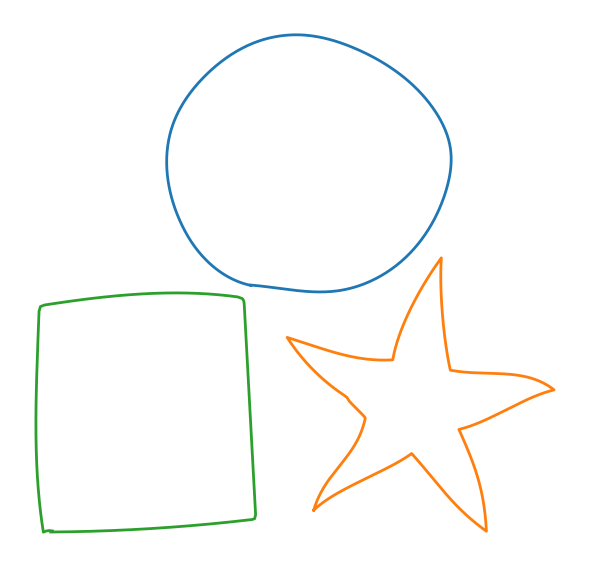

Final Output :


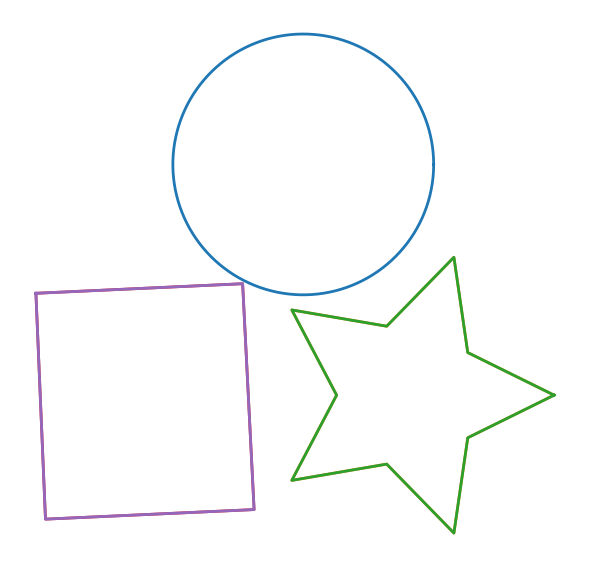

In [16]:
def main(path_of_csv=None):
    if path_of_csv is None:
        print("No csv file provided")
        return
    
    # Read the csv file
    paths_XYs = read_csv_adobe(path_of_csv)
    
    # Display the original file
    print("Original CSV File -")
    plot_and_save(paths_XYs, save_path="files/original.png")
    
    # Finding connected components
    connected_components = process_image("files/original.png")
    
    # Store the corrected data points for final plotting
    corrected_data_points = {}
    
    IMG_HEIGHT, IMG_WIDTH = 255, 255
    
    # Load the pre-trained model
    # model = load_model('model/my_model.keras')  
    # Iterate over all connected components
    for component_id, coords in connected_components.items():
        # Create a blank image for the current ID
        img = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
        # img[coords[:, 0], coords[:, 1]] = 255  # Plot the points of the current component in white
        
        # # Convert to a 3-channel image
        # img_rgb = np.stack((img, img, img), axis=-1)
        
        # # Run the model on the created image
        # img_input = np.expand_dims(img_rgb, axis=0)
        # prediction = model.predict(img_input)
        # predicted_class = np.argmax(prediction, axis=1)[0]
        predicted_class = 10
        # Regularize based on the predicted class
        if predicted_class == 0:
            # Regularize as baseball (implement the function for baseball)
            corrected_x, corrected_y = regularize_baseball(coords[:, 1], coords[:, 0])
        elif predicted_class == 1:
            # Regularize as bread (implement the function for bread)
            corrected_x, corrected_y = regularize_bread(coords[:, 1], coords[:, 0])
        elif predicted_class == 2:
            # Regularize as circle
            corrected_x, corrected_y = refine_points_to_circle(coords[:, 1], coords[:, 0])
        elif predicted_class == 3:
            # Regularize as hexagon (implement the function for hexagon)
            corrected_x, corrected_y = regularize_hexagon(coords[:, 1], coords[:, 0])
        elif predicted_class == 4:
            # Regularize as moon (implement the function for moon)
            corrected_x, corrected_y = regularize_moon(coords[:, 1], coords[:, 0])
        elif predicted_class == 5:
            # None: No regularization, use original points
            corrected_x, corrected_y = coords[:, 1], coords[:, 0]
        elif predicted_class == 6:
            # Regularize as octagon (implement the function for octagon)
            corrected_x, corrected_y = regularize_octagon(coords[:, 1], coords[:, 0])
        elif predicted_class == 7:
            # Regularize as square (implement the function for square)
            corrected_x, corrected_y = refine_points_to_square(coords[:, 1], coords[:, 0])
        elif predicted_class == 8:
            # Regularize as star (implement the function for star)
            corrected_x, corrected_y = regularize_star(coords[:, 1], coords[:, 0])
        else:
            continue
        
        # Store the corrected data points
        corrected_data_points[component_id] = (corrected_x, corrected_y)
        
    output_path = 'files/output.csv'

    # Step 1: Read and parse CSV
    path_XYs = read_csv_new(path_of_csv)

    # Step 2: Detect shapes
    detected_shapes = detect_shapes(path_XYs)

    # Step 3: Regularize shapes
    regularized_shapes = regularize_shapes(detected_shapes)

    # Step 4: Write output CSV
    write_csv(output_path, regularized_shapes)
    print("Final Output :")
    plot_csv(read_csv_adobe(output_path))

# Example usage
path_of_csv = '../problems/isolated.csv'
main(path_of_csv)
